In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint


import webbrowser
import threading
from pathlib import Path



[01:43:38 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '10010034', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010038', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8029306', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '8029307', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '10010040', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010033', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010036', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8029305', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '10010035', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010037', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010039', 'name': '_appbundles', 'system': 

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[01:43:43 -0600] [INFO]: Graph 'SteamGraph' exists.
[01:43:43 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14951 nodes and 70478 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jU8NXka---', 'numberOfShards': 1, 'replicationFactor': 3, 'minReplicationFactor': 1, 'writeConcern': 1, 'isSmart': False, 'isSatellite': False, 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Users/88659639 Users/88659639
Users/155844529 Users/155844529
Users/192044880 Users/192044880
Users/305130721 Users/305130721
Games/12739_ghost_encounters_deadwood_collector_s_edition Games/12739_ghost_encounters_deadwood_collector_s_edition
Users/175820566 Users/175820566
Users/117106617 Users/117106617
Users/240135073 Users/240135073
Users/99074324 Users/99074324
Users/29777760 Users/29777760


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14951 nodes and 70478 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
Games
_analyzers
_apps
_graphs
_frontend
plays
Users
_queues
_aqlfunctions
_jobs
_appbundles

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '208433656', '_id': 'Users/208433656', '_rev': '_jT6zLKG--j', 'type': 'Users', 'steamid': 208433656}
{'_key': '191933539', '_id': 'Users/191933539', '_rev': '_jT6zLWy--n', 'type': 'Users', 'steamid': 191933539}
{'_key': '108575170', '_id': 'Users/108575170', '_rev': '_jT6zK3S--m', 'type': 'Users', 'steamid': 108575170}
----------
Sample Plays Edges:
{'_key': '19893', '_id': 'plays/19893', '_from': 'Users/33013552', '_to': 'Games/11555_outlast', '_rev': '_jT6zTS---l', 'weight': 0.3}
{'_key': '29960', '_id': 'plays/29960', '_from': 'Users/99264709', '_to': 'Games/11368_realm_of_the_mad_god', '_rev': '_jT6zUE---O', 'weight': 23}
{'_key': '43346', '_id': 'plays/43346', '_from': 'Users/106054679', '_to': 'Games/11432_ftl_faster_than_light', '_rev': '_jT6zVA2--Y', 'weight': 0.2}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Games',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'GameName',
                                                 'type': 'str'}],
                        'example_document': {'GameName': 'The Elder Scrolls V '
                                                         'Skyrim',
                                             '_id': 'Games/11350_the_elder_scrolls_v_skyrim',
                                             '_key': '11350_the_elder_scrolls_v_skyrim',
                                             '_rev': '_jT6zNTy---',
                                     

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jT6zNTy--U', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

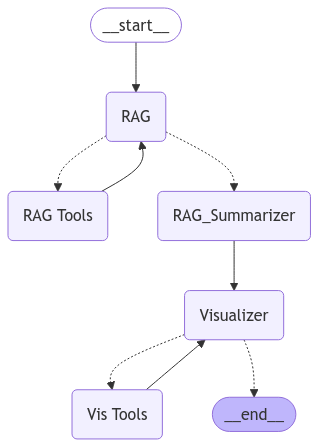

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
def create_gradio_interface(agent):
    def get_sample_data():
        # Get sample user IDs
        user_cursor = G_adb.query("""
        FOR user IN Users
        LET gameCount = (
            FOR play IN plays
            FILTER play._from == user._id
            COLLECT WITH COUNT INTO count
            RETURN count
        )[0]
        SORT gameCount DESC
        LIMIT 5
        RETURN user._id
        """)
        # Extract only the numeric ID part from the full ID (format: Users/253622624)
        sample_users = [user.split('/')[1] if '/' in user else user for user in user_cursor]

        # Get top games by player count
        games_cursor = G_adb.query("""
        WITH Games, plays
        FOR game IN Games
        LET playerCount = (
            FOR play IN plays 
            FILTER play._to == game._id 
            COLLECT WITH COUNT INTO length 
            RETURN length
        )[0]
        SORT playerCount DESC
        LIMIT 5
        RETURN game.GameName
        """)
        sample_games = [game for game in games_cursor]

        return sample_users, sample_games
    
    # Add a copy function
    def copy_to_input(text, current_input):
        if current_input:
            return current_input + " " + text
        return text

    def display_response(input_text):
        # Use a timestamp to differentiate between different query executions
        from datetime import datetime
        timestamp = datetime.now().strftime("%H:%M:%S")
        
        print(f"\n[{timestamp}] Processing new query: {input_text}")
        
        # Process the query
        result = agent.query_graph(input_text)
        
        print(f"[{timestamp}] Query processing completed")

        
            # Add more verbose debugging
        print(f"[{timestamp}] Result keys: {list(result.keys())}")
        print(f"[{timestamp}] Has_Visualization value: {result.get('Has_Visualization')}")
        print(f"[{timestamp}] Has_Visualization type: {type(result.get('Has_Visualization'))}")
        has_visualization = str(result.get("Has_Visualization", "")).lower() == "true"
        print(f"[{timestamp}] Final has_visualization value: {has_visualization}")
        # Return both the response and whether to show the visualization button
        return result["rag_reply"], has_visualization
    
    def open_html_in_new_tab():
        # Path to the HTML file
        html_path = Path("generated.html").absolute()
        
        # Check if file exists
        if not html_path.exists():
            return "Error: generated.html file not found."
        
        # Convert to file URL format
        file_url = f"file://{html_path}"
        
        # Open URL in a new tab using threading to avoid blocking
        threading.Thread(target=lambda: webbrowser.open_new_tab(file_url)).start()
        
        return "Opening visualization in a new browser tab..."
    
    # Get sample data from graph
    sample_users, sample_games = get_sample_data()
    # Custom JavaScript for copy functionality
 

    
    css = """
    .sample-panel {
        background: #2d2d2d;
        border-radius: 8px;
        padding: 15px;
        margin-top: 10px;
    }
    
    .sample-panel h3 {
        color: #f0f0f0;
        font-size: 16px;
        margin-bottom: 10px;
        text-align: center;
        border-bottom: 1px solid #444;
        padding-bottom: 5px;
    }
    
    .sample-item {
        display: flex;
        align-items: center;
        margin-bottom: 8px;
        gap: 8px;
    }
    
    .sample-text {
        font-family: monospace;
        background: #333;
        padding: 4px 8px;
        border-radius: 4px;
        flex-grow: 1;
    }
    
    .copy-btn {
        padding: 2px 8px !important;
        min-width: unset !important;
        height: 26px !important;
        font-size: 12px !important;
    }


        /* Increase text size for query input */
    .larger-text textarea {
        font-size: 18px !important;
        line-height: 1.5 !important;
    }

    /* Increase text size for result output */
    .analysis-result {
        font-size: 18px !important;
        line-height: 1.6 !important;
        padding: 15px;
        margin-top: 15px;
        min-height: 100px;
        max-height: 500px;
        overflow-y: auto;
    }

    .analysis-result p, .analysis-result li {
        font-size: 18px !important;
    }

    .analysis-result strong, .analysis-result b {
        font-weight: bold;
        font-size: 18px !important;
    }   
    """
    
     # Sample IDs panel with copyable items

    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# GAIA")
         
    
        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="Query",
                    placeholder="Enter your graph query here...",
                    lines=2,
                    elem_classes=["larger-text"]
                )
                submit_btn = gr.Button("Process Query", variant="primary")
                
                # Move text output below the analyze button
                text_output = gr.Markdown(
                    label="Analysis Result", 
                    elem_classes=["analysis-result"]
                )
                
                # Place the visualization button below the text output
                open_btn = gr.Button("Open Visualization in New Tab", visible=False)
            
            # Sample IDs panel
            with gr.Column(scale=1):
                # Create a simple interface with buttons for each item
                with gr.Column(elem_classes=["sample-panel"]):
                    gr.Markdown("### Sample User IDs")
                    
                    # Create a row of buttons for each user ID
                    for user in sample_users:
                        user_btn = gr.Button(f"{user}", elem_classes=["sample-text"])
                        user_btn.click(
                            fn=copy_to_input, 
                            inputs=[gr.Textbox(value=user, visible=False), input_text], 
                            outputs=input_text
                        )
                
                # Games section
                with gr.Column(elem_classes=["sample-panel"]):
                    gr.Markdown("### Popular Games")
                    
                    # Create a row of buttons for each game
                    for game in sample_games:
                        game_btn = gr.Button(f"{game}", elem_classes=["sample-text"])
                        game_btn.click(
                            fn=copy_to_input, 
                            inputs=[gr.Textbox(value=game, visible=False), input_text], 
                            outputs=input_text
                        )
        
        def update_ui(response, show_button):
            print(f"update_ui called with show_button={show_button}")
            return response, gr.update(visible=show_button)
                    
        # THIS IS THE FIXED LINE - Use lambda to call update_ui with the results from display_response
        submit_btn.click(
            fn=lambda x: update_ui(*display_response(x)),
            inputs=[input_text],
            outputs=[text_output, open_btn]
        )
        
        open_btn.click(
            fn=open_html_in_new_tab,
            inputs=[],
            outputs=[]
        )

    return interface

In [18]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



[01:44:37] Processing new query: total games

Processing Agent State:

Data Preview:
{}


/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:205: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  aql_generation_chain = LLMChain(llm=llm, prompt=aql_generation_prompt)
/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:257: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  aql_generation_output = self.aql_generation_chain.run(


AQL tool query
Count the total number of games in the Games collection.


> Entering new ArangoGraphDirectChain chain...
AQL Query (1):
WITH Games
RETURN LENGTH(Games)

AQL Result Successfully Obtained:

> Finished chain.

Processing Agent State:

Data Preview:
{'total_games_count': [3600]}

RAG_Summarizer State:

Updating RAG_reply with:
The total number of games is 3,600.
Visualizer State:
[ HumanMessage(content='total games', additional_kwargs={}, response_metadata={}, id='e999ccf5-0830-4595-8d14-eeb1f07a4c34'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_czGhoYCtCAegcFg9dzDsVpTf', 'function': {'arguments': '{"query":"Count the total number of games in the Games collection.","name":"total_games_count"}', 'name': 'AQL_QueryWrapper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1159, 'total_tokens': 1191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 